In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import argparse
import breizhcrops
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Functions for dataset definition

In [6]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
import torch
import pandas as pd
import os
import sklearn.metrics


def get_datasets(datapath, mode, batchsize, preload_ram=False, level="L2A"):
    print(f"Setting up datasets in {os.path.abspath(datapath)}, level {level}")
    datapath = os.path.abspath(datapath)

    frh01 = breizhcrops.BreizhCrops(region="frh01", root=datapath,
                                    preload_ram=preload_ram, level=level)
    frh02 = breizhcrops.BreizhCrops(region="frh02", root=datapath,
                                    preload_ram=preload_ram, level=level)
    frh03 = breizhcrops.BreizhCrops(region="frh03", root=datapath,
                                    preload_ram=preload_ram, level=level)
    if not "validation_only" in mode:
            frh04 = breizhcrops.BreizhCrops(region="frh04", root=datapath,
                                            preload_ram=preload_ram, level=level)

    if mode == "evaluation" or mode == "evaluation1":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02, frh03])
        testdataset = frh04
    elif mode == "validation_only":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])
        validationdataset = frh03
    elif mode == "validation_test":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])
        validationdataset = frh03
        testdataset = frh04
        
    elif mode == 'all_zones':
        traindatasets = frh01
        testdataset1 = frh02
        testdataset2 = frh03        
        testdataset3 = frh04
        
    else:
        raise ValueError("only --mode 'validation' or 'evaluation' allowed")
    meta = dict(
        ndims=13 if level=="L1C" else 10,
        num_classes=len(frh01.classes),
        sequencelength=45
    )

    return traindatasets, testdataset1, testdataset2, testdataset3, meta   

def get_dataloader(traindatasets,testdataset, validationdataset=None, batchsize=32, workers=0):
    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=workers)
    validationdataloader = DataLoader(validationdataset, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader = DataLoader(testdataset, batch_size=batchsize, shuffle=False, num_workers=workers)

    return traindataloader, validationdataloader, testdataloader

def get_dataloader2(traindatasets,testdataset1, testdataset2, testdataset3, batchsize=32, workers=0):
    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader1 = DataLoader(testdataset1, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader2 = DataLoader(testdataset2, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader3 = DataLoader(testdataset3, batch_size=batchsize, shuffle=True, num_workers=workers)

    return traindataloader, testdataloader1, testdataloader2, testdataloader3


def metrics(y_true, y_pred, training = False):
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred)
    f1_micro = sklearn.metrics.f1_score(y_true, y_pred, average="micro")
    f1_macro = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    f1_weighted = sklearn.metrics.f1_score(y_true, y_pred, average="weighted")
    recall_micro = sklearn.metrics.recall_score(y_true, y_pred, average="micro")
    recall_macro = sklearn.metrics.recall_score(y_true, y_pred, average="macro")
    recall_weighted = sklearn.metrics.recall_score(y_true, y_pred, average="weighted")
    precision_micro = sklearn.metrics.precision_score(y_true, y_pred, average="micro")
    precision_macro = sklearn.metrics.precision_score(y_true, y_pred, average="macro")
    precision_weighted = sklearn.metrics.precision_score(y_true, y_pred, average="weighted")
    
    if training == True:
        return accuracy
    
    return dict(
        accuracy=accuracy,
        kappa=kappa,
        f1_micro=f1_micro,
        f1_macro=f1_macro,
        f1_weighted=f1_weighted,
        recall_micro=recall_micro,
        recall_macro=recall_macro,
        recall_weighted=recall_weighted,
        precision_micro=precision_micro,
        precision_macro=precision_macro,
        precision_weighted=precision_weighted,
    )

# Define params

In [7]:
zones = 4
num_classes=9
d_model=64
n_head=2
n_layers=3
d_inner=128

In [8]:
datapath = Path('breizhcrops_dataset')
mode = 'all_zones'
batch_size = 256
learning_rate = 0.001

weight_decay = 5e-08
workers = 4

# Define Dataloader

In [9]:
zone1dataset, zone2dataset, zone3dataset, zone4dataset, meta = get_datasets(datapath=datapath, mode=mode,
                                                        batchsize=batch_size, 
                                                        preload_ram=True, level="L2A")
num_classes = meta["num_classes"]
ndims = meta["ndims"]
sequencelength = meta["sequencelength"]

loading data into RAM:   0%|          | 0/178632 [00:00<?, ?it/s]

Setting up datasets in /home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset, level L2A


loading data into RAM: 100%|██████████| 122708/122708 [00:34<00:00, 3596.71it/s]


In [11]:
zone1dataloader, zone2dataloader, zone3dataloader, zone4dataloader = get_dataloader2(zone1dataset, zone2dataset, 
                                                                                     zone3dataset, zone4dataset,
                                                                                     batchsize=batch_size, 
                                                                                     workers=workers)

# Define DANN Transformer

In [10]:
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU

import torch.nn as nn
import torch.nn.functional as F

__all__ = ['FeatureExtractor']

class FeatureExtractor(nn.Module):
    def __init__(self, input_dim=10, d_model=64, n_head=2, n_layers=5,
                 d_inner=128, activation="relu", dropout=0.017998950510888446):

        super(FeatureExtractor, self).__init__()
        self.modelname = f"FeatureExtractor_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)

    def forward(self,x):
        x = self.inlinear(x)
        x = self.relu(x)
        x = x.transpose(0, 1) # N x T x D -> T x N x D
        x = self.transformerencoder(x)
        x = x.transpose(0, 1) # T x N x D -> N x T x D
        x = x.max(1)[0]
        x = self.relu(x)

        return x

In [12]:
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU, GELU

import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat

__all__ = ['ViTransformerExtractor']

class ViTransformerExtractor(nn.Module):
    def __init__(self, input_dim=10, num_classes=9, time_dim = 45, d_model=64, n_head=2, n_layers=5,
                 d_inner=128, activation="relu", dropout=0.1):

        super(ViTransformerExtractor, self).__init__()
        self.modelname = f"TransformerEncoder_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)

        self.pos_embedding = nn.Parameter(torch.randn(1, time_dim, d_model)) # T + class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # class token

        self.dropout = nn.Dropout(dropout)

        self.n_units  = 128

    def forward(self,x):

        x = self.inlinear(x) # B x T x D

        b, n, _ = x.shape # B x T x D

        #cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)  # repeat for all batch
        #x = torch.cat((cls_tokens, x), dim=1) # concatenate on sequence [T + class token]
        x += self.pos_embedding[:, :(n)]
        
        x = x.transpose(0, 1) # N x T x D -> T x N x D
        x = self.transformerencoder(x)
        x = x.transpose(0, 1) # T x N x D -> N x T x D

        features = x.max(1)[0]  # take first dimension B x T x D
        
        return features

In [13]:
#feature_ex = FeatureExtractor(input_dim=ndims, d_model=64, n_head=2, n_layers=5, activation="relu",).to(device)

In [14]:
feature_ex = ViTransformerExtractor(input_dim=ndims, n_head = n_head, n_layers = n_layers, activation="relu",).to(device)

In [15]:
#DANN model: an additional fully-connected branch is added for the domain classifier
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

__all__ = ['ViTransformerDANN']

class ViTransformerDANN(nn.Module):
    def __init__(self, feature_ex, input_dim=13, num_classes=9, d_model=64, n_head=2, n_layers=5, n_domain=2,
                 d_inner=128, activation="relu", dropout=0.1):

        super(ViTransformerDANN, self).__init__()
        self.modelname = f"TransformerEncoder_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)
        self.n_units  = 128
        self.fc1 = Linear(d_model, self.n_units)
        self.fc2 = Linear(d_model, self.n_units)
        self.outlinear = Linear(self.n_units, num_classes)
        
        self.dropout_p = 0.1
        self.dropout = nn.Dropout(p = self.dropout_p)
        self.outlinear_dom = Linear(self.n_units, n_domain)
        
        self.mlp_head = nn.Sequential(
            LayerNorm(d_model),
            Linear(d_model, self.n_units),
            ReLU(),
            nn.Dropout(p = self.dropout_p),
            Linear(self.n_units, num_classes)
        )

        self.features = feature_ex
    
    def forward(self, x, alpha=None):
        embeddings = self.features(x)

        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(embeddings, alpha)
            x = self.fc2(reverse_feature)
            x = self.relu(x)
            x = self.dropout(x)
            domain_output = self.outlinear_dom(x)
            return domain_output

        # If we don't pass alpha, we assume we are training with supervision
        else:
            # pass features to labels classifier
            class_logits = self.mlp_head(embeddings)

            return embeddings, class_logits

In [ ]:
#DANN model: an additional fully-connected branch is added for the domain classifier
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

__all__ = ['TransformerDANNModel']

class TransformerDANNModel(nn.Module):
    def __init__(self, feature_ex, input_dim=13, num_classes=9, d_model=64, n_head=2, n_layers=5, n_domain=2,
                 d_inner=128, activation="relu", dropout=0.017998950510888446):

        super(TransformerDANNModel, self).__init__()
        self.modelname = f"TransformerEncoder_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)
        self.n_units  = 128
        self.fc1 = Linear(d_model, self.n_units)
        self.fc2 = Linear(d_model, self.n_units)
        self.outlinear = Linear(self.n_units, num_classes)
        self.dropout_p = 0.2
        self.dropout = nn.Dropout(p = self.dropout_p)
        self.outlinear_dom = Linear(self.n_units, n_domain)
 
        self.features = feature_ex
    
    def forward(self, x, alpha=None):
        embeddings = self.features(x)

        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(embeddings, alpha)
            x = self.fc2(reverse_feature)
            x = self.relu(x)
            x = self.dropout(x)
            domain_output = self.outlinear_dom(x)
            return domain_output

        # If we don't pass alpha, we assume we are training with supervision
        else:
            # pass features to labels classifier
            x = self.fc1(embeddings)
            x = self.relu(x)
            x = self.dropout(x)
            class_output = self.outlinear(x)
            return embeddings, class_output

In [16]:
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes, n_layers = n_layers, 
                                n_domain=2,
                                activation="relu",).to(device)

dann_model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
print(f"Initialized {dann_model.modelname}")

logdir = 'logs/torch_transformer_dann/'

print(f"Initialized {dann_model.modelname}")
os.makedirs(logdir, exist_ok=True)
print(f"Logging results to {logdir}")

Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08
Logging results to logs/torch_transformer_dann/


In [15]:
#dann_model = TransformerDANNModel(feature_ex, input_dim=ndims, num_classes=num_classes, n_layers = 2, n_domain=2,
#                activation="relu",).to(device)

dann_model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
print(f"Initialized {dann_model.modelname}")

logdir = 'logs/torch_transformer_dann/'

print(f"Initialized {dann_model.modelname}")
os.makedirs(logdir, exist_ok=True)
print(f"Logging results to {logdir}")

Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08_learning-rate=0.001_weight-decay=5e-08
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08_learning-rate=0.001_weight-decay=5e-08
Logging results to logs/torch_transformer_dann/


# Prepare Training Functions

In [17]:
def train_epoch(dann_model, optimizer, criterion, traindataloader, testdataloader, device, 
                running_loss1, running_loss2, running_loss3, alpha):
    
    dann_model.train()
    losses = list()
    y_true_list = list()
    y_pred_list = list()
    
    dataloader_iterator = iter(testdataloader)
    
    with tqdm(enumerate(traindataloader), total=len(traindataloader), leave=True) as iterator:
        for idx, batch in iterator:
            optimizer.zero_grad()
            x, y_true, _ = batch
            x = x.to(device)
            y_true = y_true.to(device)
            
            embds, logits = dann_model.forward(x)
            Gy_loss = criterion(logits, y_true)
            running_loss1 += Gy_loss.item()
            Gy_loss.backward()
            
            y_true_list.append(y_true)
            y_pred_list.append(logits.argmax(-1))
            iterator.set_description(f"train loss={Gy_loss:.2f}")
            losses.append(Gy_loss)
            
            #2 - train Gd on source domain data, the label is zero for all samples
            #Forward pass to the Gd discriminator
            Gd_outputs_source = dann_model(x, alpha)
            domain_labels0 = torch.zeros(y_true.size(0), dtype=torch.int64).to(device)
            Gd_loss_s = criterion(Gd_outputs_source, domain_labels0)
            running_loss2 += Gd_loss_s.item()
            Gd_loss_s.backward()  # backward pass: computes gradients

            #3 - train discriminator Gd on target domain data, the label is 1 for all samples
            #iterate batch from target domain dataloader
            try:
                batch = next(dataloader_iterator)
                x, y_true, _ = batch
          
            except StopIteration:
                dataloader_iterator = iter(testdataloader)
                batch = next(dataloader_iterator)
                x, y_true, _ = batch

            x = x.to(device)
            y_true = y_true.to(device)
            #Forward pass to Gd with target domain data
            Gd_outputs_target = dann_model(x, alpha)
            domain_labels1 = torch.ones(y_true.size(0), dtype=torch.int64).to(device)
            Gd_loss_t = criterion(Gd_outputs_target, domain_labels1)
            running_loss3 += Gd_loss_t.item()
            Gd_loss_t.backward()  # backward pass: computes gradients

            optimizer.step() # update weights based on accumulated gradients

    return running_loss1, running_loss2, running_loss3, torch.stack(losses), torch.cat(y_true_list), torch.cat(y_pred_list)


def test_epoch(model, criterion, dataloader, device):
    model.eval()
    with torch.no_grad():
        losses = list()
        y_true_list = list()
        y_pred_list = list()
        y_score_list = list()
        field_ids_list = list()
        with tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
            for idx, batch in iterator:
                x, y_true, field_id = batch
                embds, logits = model.forward(x.to(device))
                loss = criterion(logits, y_true.to(device))
                iterator.set_description(f"test loss={loss:.2f}")
                losses.append(loss)
                y_true_list.append(y_true)
                y_pred_list.append(logits.argmax(-1))
                y_score_list.append(logits.exp())
                field_ids_list.append(field_id)
        return torch.stack(losses), torch.cat(y_true_list), torch.cat(y_pred_list), torch.cat(y_score_list), torch.cat(field_ids_list)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(logdir)

In [ ]:
import matplotlib.pyplot as plt
epochs = 250
alpha = np.empty(epochs)
p = np.linspace(0.0,1.0,epochs)

gammas = [4,5,8,10]
for gamma in gammas:
    alpha = 0.5*(2/(1+np.exp(-gamma*p)) - 1)

    plt.plot(range(epochs), alpha)

# Training loop DANN

In [ ]:
zones = 4
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
epochs = 250

#set domain adaptation parameter schedule
p = np.linspace(0.0,1.0,epochs)
gamma = 10
alphas = 0.2*(2/(1+np.exp(-gamma*p)) - 1)

# set constant alpha
alpha_c = 0.2
#alphas = alpha_c * np.ones(epochs, dtype = np.float32)

save_freq = 10

for i in range(zones):
    
    traindataloader = dataloaders[i][0]
    train_zone = dataloaders[i][1]
    print('Training zone:', train_zone)
    
    for j in range(zones):
        if j!= i:
            # DEFINE MODE DIR AND NAME
                # if alpha scheduled save model as:
            path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_maxalpha02_gamma'+str(gamma)
            #path = 'models/torch_transformer/trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_gamma'+str(gamma)
                # if constant alpha save model as:
            #path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_alpha'+str(alpha_c)
            model_dir = Path(path)
            
            # DEFINE MODEL
            feature_ex = ViTransformerExtractor(input_dim=ndims, n_head = n_head, n_layers = n_layers, activation="relu",).to(device)
            dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes,
                                            n_layers = n_layers, 
                                            n_domain=2,
                                            activation="relu",).to(device)

            dann_model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
            print(f"Initialized {dann_model.modelname}")
            
            # SET LOSS
            criterion = torch.nn.CrossEntropyLoss(reduction="mean")

            # SET OPTIMIZER AND LR SCHEDULER
            optimizer = Adam(dann_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            lambda2 = lambda epoch: 0.99 ** epoch
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)
            
            # SET TARGET DATA
            testdataloader = dataloaders[j][0]
            test_zone = dataloaders[j][1]
            print('Testing zone:', test_zone)
            
            for epoch in range(epochs):
                alpha = alphas[epoch]

                running_loss1 = 0.0
                running_loss2 = 0.0
                running_loss3 = 0.0

                running_loss1, running_loss2, running_loss3, train_loss, y_true, y_pred  = train_epoch(dann_model, optimizer, criterion,
                                                                        traindataloader,testdataloader, device, 
                                                                        running_loss1, running_loss2, running_loss3, alpha)
                loss_step = running_loss1 / len(traindataloader)
                loss_Gd_source = running_loss2 / len(traindataloader)
                loss_Gd_target = running_loss3 / len(testdataloader)

                train_scores = metrics(y_true.cpu(), y_pred.cpu())

                # Record loss and accuracy into the writer for training
               #writer.add_scalar('Train Gy/Loss', loss_step, epoch)
                train_accuracy = train_scores["accuracy"]
                #writer.add_scalar('Train Gy/Accuracy', train_accuracy, epoch)
                #writer.add_scalar('Train Gd source/Loss', loss_Gd_source, epoch)
                #writer.add_scalar('Train Gd source/Loss', loss_Gd_target, epoch)
                #writer.flush()

                scheduler.step()

                train_loss = train_loss.cpu().detach().numpy()[0]
            #    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)
                print(f"epoch {epoch}: trainloss {train_loss:.2f} ")

                if epoch % save_freq == 0:
                    torch.save(dann_model.state_dict(), model_dir)
            torch.save(dann_model.state_dict(), model_dir)

# Test

In [ ]:
zones = 4
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]

# DEFINE MODEL
#feature_ex = FeatureExtractor(input_dim=ndims, n_layers = 2, activation="relu",).to(device)
#dann_model = TransformerDANNModel(feature_ex, input_dim=ndims, num_classes=num_classes, n_layers = 2, n_domain=2,
#    activation="relu",).to(device)

feature_ex = ViTransformerExtractor(input_dim=ndims, n_head = n_head, n_layers = n_layers, activation="relu",).to(device)
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes,
                                n_layers = n_layers, n_domain=2,activation="relu",).to(device)

criterion = torch.nn.CrossEntropyLoss(reduction="mean")

for i in range(zones):
    
    traindataloader = dataloaders[i][0]
    train_zone = dataloaders[i][1]
    print('Source zone:', train_zone)
    
    for j in range(zones):
        if j!= i:
            # DEFINE MODE DIR AND NAME
                # if alpha scheduled save model as:
            path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_maxalpha02_gamma'+str(gamma)
                # if constant alpha save model as:
            #path = 'models/torch_transformer/vio_trasformer_dann_s'+str(i+1)+'_t'+ str(j+1)+'_alpha'+str(alpha_c)
            model_dir = Path(path)
            dann_model.load_state_dict(torch.load(model_dir))
            
            # SET TARGET DATA
            testdataloader = dataloaders[j][0]
            test_zone = dataloaders[j][1]
            print('Target zone:', test_zone)

            test_loss, y_true, y_pred, *_ = test_epoch(dann_model, criterion, testdataloader, device)

            scores = metrics(y_true.cpu(), y_pred.cpu())
            scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
            test_loss = test_loss.cpu().detach().numpy()[0]
            print(scores)

In [18]:
zones = 4
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
feature_ex = ViTransformerExtractor(input_dim=ndims, n_head = n_head, n_layers = n_layers, activation="relu",).to(device)
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes,
                                n_layers = n_layers, n_domain=2,activation="relu",).to(device)

path = 'models/torch_transformer/vio_trasformer_dann_s2_t3_maxalpha02_gamma10'
model_dir = Path(path)
dann_model.load_state_dict(torch.load(model_dir))

criterion = torch.nn.CrossEntropyLoss(reduction="mean")

# SET TARGET DATA
ZONE = 3
testdataloader = dataloaders[ZONE-1][0]
test_zone = dataloaders[ZONE-1][1]
print('Target zone:', test_zone)

test_loss, y_true, y_pred, *_ = test_epoch(dann_model, criterion, testdataloader, device)

scores = metrics(y_true.cpu(), y_pred.cpu())
scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])

test_loss = test_loss.cpu().detach().numpy()[0]
print(scores)

Target zone: zone3


test loss=1.59: 100%|██████████| 650/650 [00:13<00:00, 48.30it/s]


{'accuracy': 0.6517458390185553, 'kappa': 0.5498264929825796, 'f1_micro': 0.6517458390185553, 'f1_macro': 0.45454374789308666, 'f1_weighted': 0.6579960230383469, 'recall_micro': 0.6517458390185553, 'recall_macro': 0.4563277913262177, 'recall_weighted': 0.6517458390185553, 'precision_micro': 0.6517458390185553, 'precision_macro': 0.4741841255267145, 'precision_weighted': 0.6824591901604888}


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
label_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'permanent_meadows', 'temporary_meadows']


In [20]:
y_pred_names = [label_names[i] for i in y_pred]

In [22]:
field_parcels_geodataframe_dann = zone3dataset.geodataframe()
field_parcels_geodataframe = zone3dataset.geodataframe()
field_parcels_geodataframe_dann['classname'] = y_pred_names

frh03.tar.gz: 48.1MB [00:21, 2.28MB/s]                            


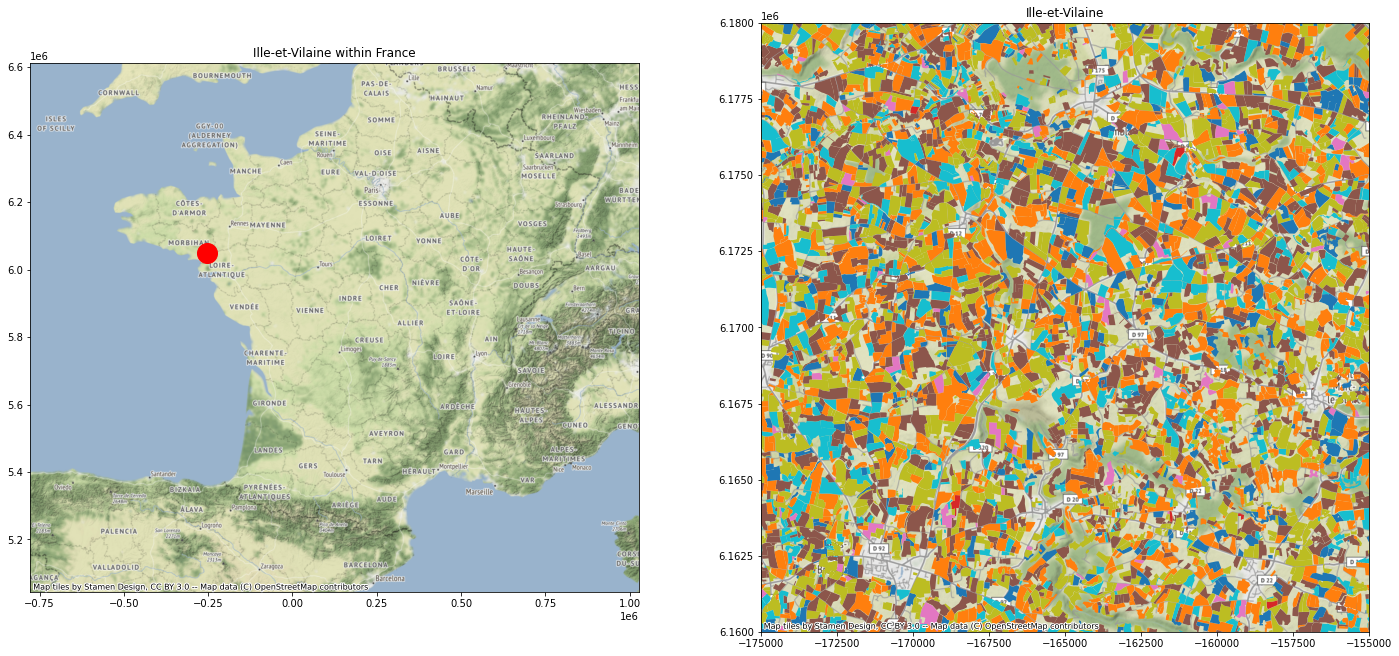

In [36]:
import contextily as ctx
fig,axs = plt.subplots(1,2, figsize=(24,12))

ax = axs[0]
france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
ax.set_xlim(*france_xlim)
ax.set_ylim(*france_ylim)

ctx.add_basemap(ax)

ymin, xmin, ymax, xmax = field_parcels_geodataframe.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
ax.plot([ymin],[xmin],"ro", markersize=20)
ax.set_title("Ille-et-Vilaine within France")

ax = axs[1]
ax = field_parcels_geodataframe_dann.to_crs(epsg=3857).plot(column="classname", ax=ax, legend=False)
ax.set_title("Ille-et-Vilaine")
ax.set_xlim(*(-175000,  -155000))
ax.set_ylim(*(6160000, 6180000))
ctx.add_basemap(ax)

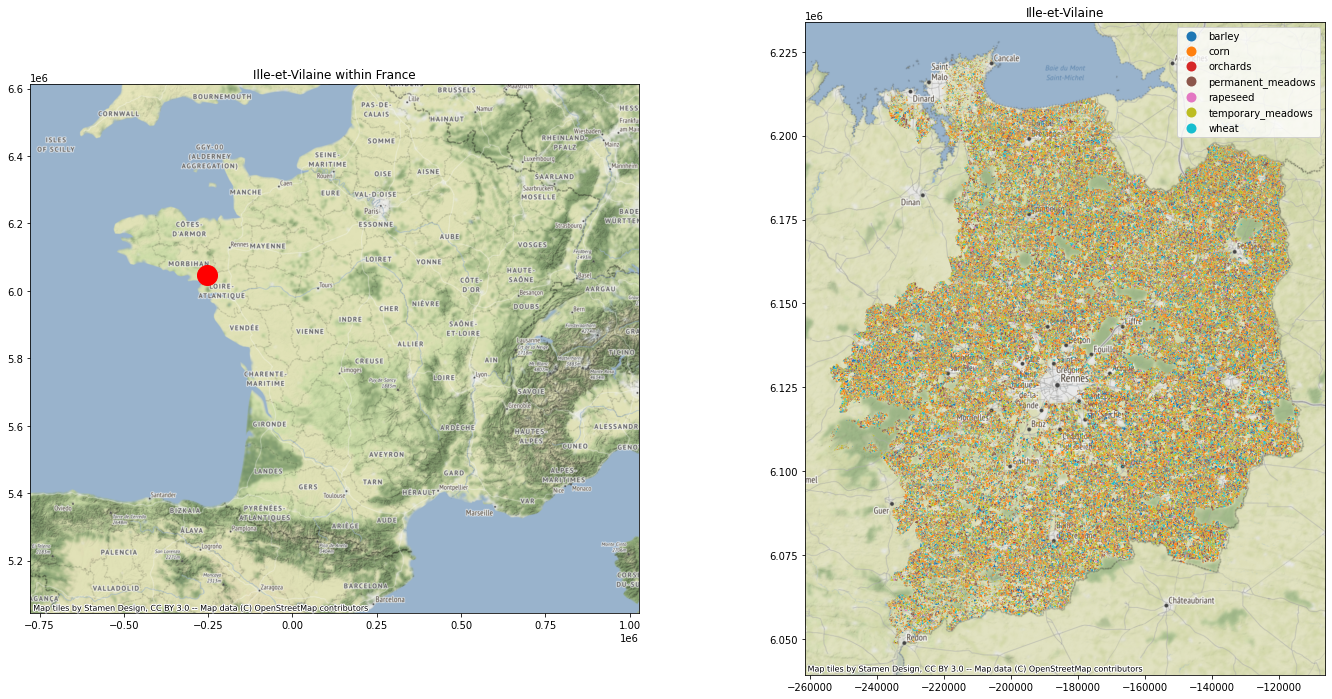

In [33]:
import contextily as ctx
fig,axs = plt.subplots(1,2, figsize=(24,12))

ax = axs[0]
france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
ax.set_xlim(*france_xlim)
ax.set_ylim(*france_ylim)

ctx.add_basemap(ax)

ymin, xmin, ymax, xmax = field_parcels_geodataframe.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
ax.plot([ymin],[xmin],"ro", markersize=20)
ax.set_title("Ille-et-Vilaine within France")

ax = axs[1]
ax = field_parcels_geodataframe_dann.to_crs(epsg=3857).plot(column="classname", ax=ax, legend=True)
ax.set_title("Ille-et-Vilaine")
ctx.add_basemap(ax)

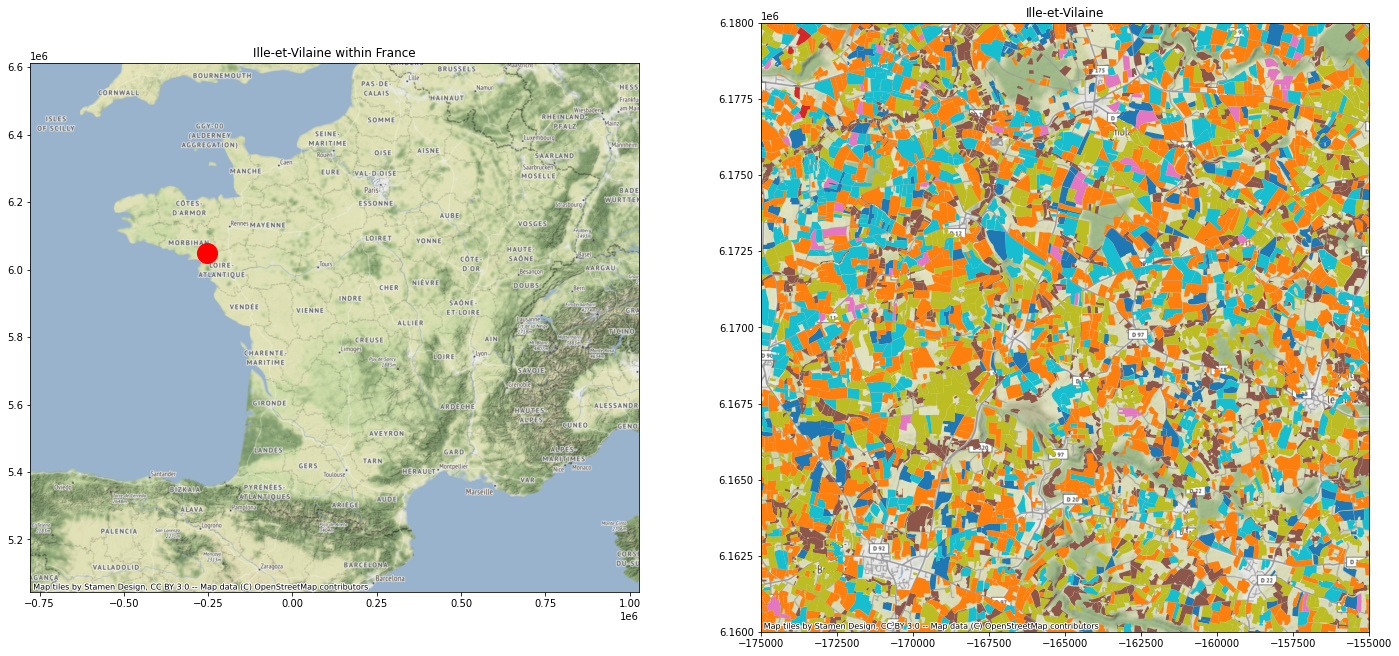

In [37]:
import contextily as ctx
fig,axs = plt.subplots(1,2, figsize=(24,12))

ax = axs[0]
france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
ax.set_xlim(*france_xlim)
ax.set_ylim(*france_ylim)

ctx.add_basemap(ax)

ymin, xmin, ymax, xmax = field_parcels_geodataframe.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
ax.plot([ymin],[xmin],"ro", markersize=20)
ax.set_title("Ille-et-Vilaine within France")

ax = axs[1]
ax = field_parcels_geodataframe.to_crs(epsg=3857).plot(column="classname", ax=ax, legend=False)
ax.set_title("Ille-et-Vilaine")
ax.set_xlim(*(-175000,  -155000))
ax.set_ylim(*(6160000, 6180000))
ctx.add_basemap(ax)

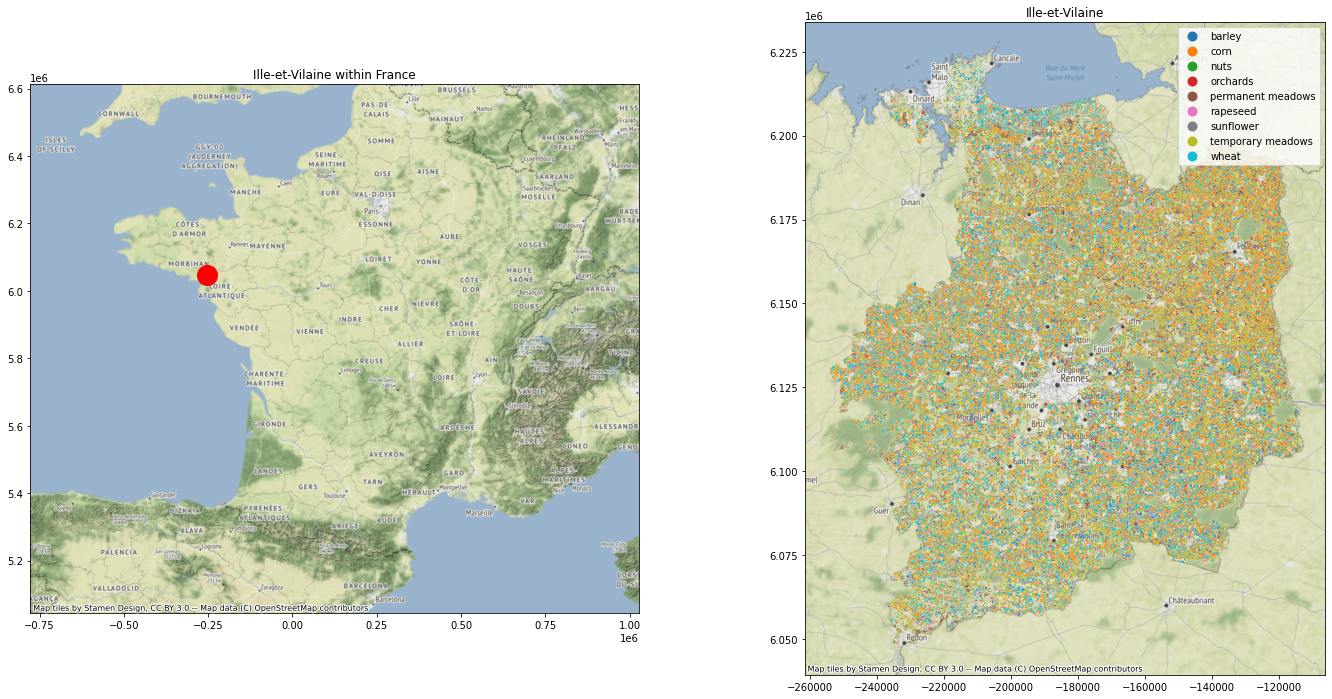

In [34]:
import contextily as ctx
fig,axs = plt.subplots(1,2, figsize=(24,12))

ax = axs[0]
france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
ax.set_xlim(*france_xlim)
ax.set_ylim(*france_ylim)

ctx.add_basemap(ax)

ymin, xmin, ymax, xmax = field_parcels_geodataframe.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
ax.plot([ymin],[xmin],"ro", markersize=20)
ax.set_title("Ille-et-Vilaine within France")

ax = axs[1]
ax = field_parcels_geodataframe.to_crs(epsg=3857).plot(column="classname", ax=ax, legend=True)
ax.set_title("Ille-et-Vilaine")
ctx.add_basemap(ax)